Optimized Number of Centers: 66
Optimized Spread Factors: 12.099599439825905
Optimized RMSE: 0.3333015437691443
Optimized R²: 0.9960316102724054
Optimized VAF: 99.60332994268997
Optimized MAE: 0.07633400973200191


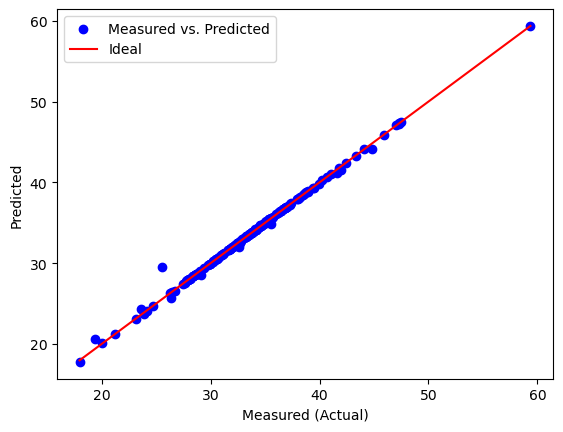

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# Define the PSO algorithm
def pso(objective_function, num_particles, num_dimensions, max_iterations):
    # PSO parameters
    W = 0.5  # inertia weight
    c1 = 2.0  # cognitive weight
    c2 = 2.0  # social weight

    # Initialize particles
    particles = np.random.uniform(low=0.001, high=10.0, size=(num_particles, num_dimensions))
    velocities = np.zeros((num_particles, num_dimensions))
    best_positions = particles.copy()
    best_scores = np.full(num_particles, -np.inf)
    global_best_position = None
    global_best_score = -np.inf

    # PSO main loop
    for _ in range(max_iterations):
        # Evaluate current particle positions
        scores = np.array([objective_function(p) for p in particles])

        # Update personal best positions and scores
        improved_indices = scores > best_scores
        best_scores[improved_indices] = scores[improved_indices]
        best_positions[improved_indices] = particles[improved_indices]

        # Update global best position and score
        best_particle_index = np.argmax(best_scores)
        if best_scores[best_particle_index] > global_best_score:
            global_best_score = best_scores[best_particle_index]
            global_best_position = best_positions[best_particle_index]

        # Update particle velocities and positions
        r1 = np.random.random((num_particles, num_dimensions))
        r2 = np.random.random((num_particles, num_dimensions))
        velocities = (W * velocities) + (c1 * r1 * (best_positions - particles)) + (c2 * r2 * (global_best_position - particles))
        particles = particles + velocities

    return global_best_position

# Radial Basis Function Neural Network (RBFNN) class
class RBFNN:
    def __init__(self, num_centers, num_features):
        self.num_centers = num_centers
        self.num_features = num_features
        self.centers = None
        self.widths = None
        self.weights = None

    def _gaussian_kernel(self, x, center, width):
        return np.exp(-np.sum((x - center) ** 2) / (2 * width ** 2))

    def _design_matrix(self, X):
        design_matrix = np.zeros((X.shape[0], self.num_centers))

        for i in range(X.shape[0]):
            for j in range(self.num_centers):
                design_matrix[i, j] = self._gaussian_kernel(X[i], self.centers[j], self.widths[j])

        return design_matrix

    def _normalize_output(self, y):
        scaler = StandardScaler()
        y_scaled = scaler.fit_transform(y)
        return y_scaled, scaler

    def _denormalize_output(self, y_scaled, scaler):
        y = scaler.inverse_transform(y_scaled)
        return y

    def fit(self, X, y):
        self.centers = X[np.random.choice(X.shape[0], self.num_centers, replace=False)]
        self.widths = np.zeros(self.num_centers)

        for i in range(self.num_centers):
            distances = np.linalg.norm(X - self.centers[i], axis=1)
            self.widths[i] = np.mean(distances)

        design_matrix = self._design_matrix(X)
        y_scaled, scaler = self._normalize_output(y)

        self.weights = np.linalg.pinv(design_matrix) @ y_scaled

        self.scaler = scaler

    def predict(self, X):
        design_matrix = self._design_matrix(X)
        y_scaled = design_matrix @ self.weights
        y = self._denormalize_output(y_scaled, self.scaler)
        return y

# Read and preprocess the dataset
dataset = shuffle(pd.read_csv("blast_dataset1.csv"))
x = dataset[['B', 'S', 'H', 'D', 'TI', 'TF', 'L', 'C', 'PF', 'RF']].values
y = dataset[['X']].values

# Normalize input features
scaler = StandardScaler()
x = scaler.fit_transform(x)

# Split the dataset into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# PSO parameters
num_particles = 50
num_dimensions = 2
max_iterations = 40

# Objective function for PSO to optimize
def objective_function(params):
    num_centers, spread_factors = params
    num_centers = max(int(round(num_centers)), 1)  # Ensure num_centers is at least 1

    rbfnn = RBFNN(num_centers=num_centers, num_features=x.shape[1])
    rbfnn.centers = x[np.random.choice(x.shape[0], num_centers, replace=False)]
    rbfnn.widths = spread_factors

    rbfnn.fit(x_train, y_train)
    y_pred = rbfnn.predict(x_test)

    rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
    return -rmse  

# Perform PSO to optimize the RBFNN hyperparameters
best_params = pso(objective_function, num_particles, num_dimensions, max_iterations)
best_num_centers, best_spread_factors = best_params

# Convert the optimized number of centers to an integer
best_num_centers = int(round(best_num_centers))

# Create an instance of RBFNN with the optimized hyperparameters
best_rbfnn = RBFNN(num_centers=best_num_centers, num_features=x.shape[1])
best_rbfnn.centers = x[np.random.choice(x.shape[0], best_num_centers, replace=False)]
best_rbfnn.widths = best_spread_factors

# Train the RBFNN with the full training set
best_rbfnn.fit(x_train, y_train)

# Predict on the test set using the optimized RBFNN
y_pred = best_rbfnn.predict(x_test)

# Calculate RMSE, R², VAF, and MAE for the optimized RBFNN
rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
ssr = np.sum((y_test - y_pred) ** 2)
sst = np.sum((y_test - np.mean(y_test)) ** 2)
r2 = 1 - (ssr / sst)
vaf = (1 - (np.var(y_test - y_pred) / np.var(y_test))) * 100
mae = np.mean(np.abs(y_pred - y_test))

# Display the results
print("Optimized Number of Centers:", best_num_centers)
print("Optimized Spread Factors:", best_spread_factors)
print("Optimized RMSE:", rmse)
print("Optimized R²:", r2)
print("Optimized VAF:", vaf)
print("Optimized MAE:", mae)

# Plot the correlation graph
plt.scatter(y_test, y_pred, c='b', label='Measured vs. Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], c='r', label='Ideal')
plt.xlabel('Measured (Actual)')
plt.ylabel('Predicted')
plt.legend()
plt.show()
